# 8-1. 프로젝트: 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약

라이브러리 버전 확인

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

- sunnysai12345/News_Summary : https://github.com/sunnysai12345/News_Summary

아래의 코드로 데이터를 다운로드할 수 있어요.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
68547,Senior journo Sajeev Gopalan assaulted by poli...,"Senior journalist Sajeev Gopalan, working for ..."
73914,Widower wanting to remarry kills daughter in D...,The Delhi Police has arrested a 28-year-old wi...
6656,I will actively participate in national politi...,Telangana Rashtra Samithi (TRS) President and ...
48729,80% Ganga to be cleaned before Kumbh Mela: Govt,Union Minister Nitin Gadkari on Wednesday said...
5311,Hollywood unions unite to fight against sexual...,Hollywood unions including the Screen Actors G...
27020,Wanted to cry on watching Sanju: Dutt's friend...,"Sanjay Dutt's friend Paresh Ghelani, on whom t..."
72055,Iran tests home-grown missile defence system,Iran has tested the Bavar 373 missile which is...
18487,"Hackers steal Amazon refunds from 1,500 users ...","Around 1,500 customers of e-commerce giant Ama..."
82366,Ex UN Secretary-General praises Modi for globa...,Former United Nations Secretary-General Ban Ki...
74769,No report of Indian casualty in Barcelona atta...,External Affairs Minister Sushma Swaraj said i...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

### Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [5]:
# 전체 데이터 갯수 확인
total_count = len(data)
print(f"Total number of rows: {total_count}")

Total number of rows: 98401


중복 샘플과 NULL 값이 존재하는 샘플 제거

In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


text 자체가 중복이 된 경우는 중복 샘플이므로 제거

In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


데이터프레임에 Null 값이 있는지 확인

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


headlines 와 text의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

text의 최소 길이 : 1
text의 최대 길이 : 91
text의 평균 길이 : 58.23813542090281
headlines_len의 최소 길이 : 1
headlines_len의 최대 길이 : 18
headlines_len의 평균 길이 : 9.553660024400163


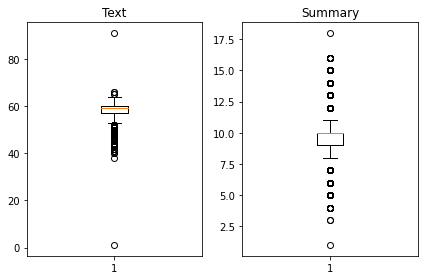

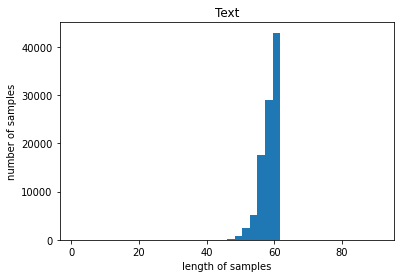

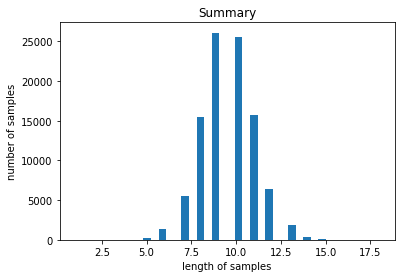

In [9]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text의 최소 길이 : {}'.format(np.min(text_len)))
print('text의 최대 길이 : {}'.format(np.max(text_len)))
print('text의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines_len의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines_len의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines_len의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- Text: text의 평균 길이가 58이므로 불용어 제거는 더 간결하고 핵심적인 정보로 만들 수 있음
- Headlines: headlines의 평균 길이가 9.5로 짧기 때문에, 불용어 제거 시 중요한 정보까지 제거될 위험. 요약 데이터는 본래 핵심 정보를 담고 있기 때문에, 불용어를 제거하는 대신 원문 그대로 사용

텍스트 정규화와 불용어 제거

- 정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거

In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- 불용어를 제거
- 영어 문자는 소문자
- 섞여있는 html 태그를 제거
- 정규 표현식을 통해 각종 특수문자를 제거

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

preprocess_sentence() test

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [14]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [15]:
# 전체 Summary 데이터에 대한 전처리: 시간이 오래 걸릴 수 있음
clean_headlines = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- empty 샘플이 생겼는지 확인
- empty 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체

In [16]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
# Null 값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
# Null 값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


샘플의 최대 길이 정하기

최대 길이는 평균 + 2*표준편차

In [19]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

# 최대 길이 계산
text_mean = np.mean(text_len)
text_std = np.std(text_len)
headlines_mean = np.mean(headlines_len)
headlines_std = np.std(headlines_len)

max_text_len = int(text_mean + 2 * text_std)
max_headlines_len = int(headlines_mean + 2 * headlines_std)

print(f"text의 최대 길이 (평균 + 2*표준편차): {max_text_len}")
print(f"headlines의 최대 길이 (평균 + 2*표준편차): {max_headlines_len}")

text의 최대 길이 (평균 + 2*표준편차): 42
headlines의 최대 길이 (평균 + 2*표준편차): 12


훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(max_text_len, data['text'])
below_threshold_len(max_headlines_len,  data['headlines'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [22]:
# max_text_len 및 max_headlines_len보다 긴 샘플 제외
# data = data[(data['text'].apply(lambda x: len(x.split())) <= max_text_len) &
#             (data['headlines'].apply(lambda x: len(x.split())) <= max_headlines_len)]
data = data[(data['text'].apply(lambda x: len(x.split())) <= max_text_len) &
            (data['headlines'].apply(lambda x: len(x.split())) <= max_headlines_len)].reset_index(drop=True).copy()

print('최대 길이 조건을 만족하는 전체 샘플 수:', len(data))

최대 길이 조건을 만족하는 전체 샘플 수: 94754


### 시작 토큰과 종료 토큰 추가하기

- seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요 있음
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input
- 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target
- 두 개의 문장 모두 headlines 열로부터 만듬

In [23]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
2,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
3,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
4,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [60]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터를 분리

In [61]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[49998 25628 39317 ... 59050 14130 77167]


In [62]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

In [63]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18950


In [64]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_target_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_target_test))

훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

In [65]:
src_tokenizer = Tokenizer(oov_token='UNK') # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인  
src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보 확인

In [66]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67935
등장 빈도가 6번 이하인 희귀 단어의 수: 46261
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21674
단어 집합에서 희귀 단어의 비율: 68.0959740928829
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5520828013550556


- 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 68% 이상을 차지
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.56%
- 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
- 단어의 등장 빈도 수를 예제와 같이 7회 미만으로 잡았는데 기준이 모호하지만 통계 결과에서는 큰 문제가 없어 보인다.
- 이를 제외한 단어 집합의 크기를 2만여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 21,000으로 제한
- 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있음

In [67]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words=src_vocab, oov_token='UNK') # 단어 집합의 크기를 21,000으로 제한하고 OOV 토큰 추가
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 재생성

- texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
- 현재 단어 집합의 크기를 21,000으로 제한했으니까 이제 21,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음

In [68]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[244, 1381, 146, 8459, 8760, 6238, 17062, 76, 60, 602, 11912, 809, 161, 10727, 832, 2, 503, 117, 1191, 1695, 2165, 89, 472, 9993, 117, 3134, 1223, 1709, 809, 2], [806, 49, 629, 301, 34, 84, 531, 15, 2993, 14995, 13442, 868, 1153, 143, 4691, 1212, 331, 839, 26, 362, 199, 590, 2226, 2129, 1973, 2, 806, 66, 920, 36, 762, 10479, 19016, 733], [268, 50, 1213, 175, 67, 1328, 801, 9994, 1793, 165, 7356, 9073, 1793, 9994, 67, 431, 1213, 2854, 465, 5167, 9994, 1640, 1421, 393, 811, 10987, 3878, 147, 1793, 3340, 1181, 883, 1221, 3830]]


- headlines 데이터에 대해서도 동일한 작업을 수행
- 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산
- 단어의 등장 빈도 수를 6회 미만으로 잡았는데 기준이 모호하지만 통계 결과에서는 큰 문제가 없어 보인다.

In [69]:
tar_tokenizer = Tokenizer(oov_token='UNK')
tar_tokenizer.fit_on_texts(decoder_input_train)

In [70]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29527
등장 빈도가 5번 이하인 희귀 단어의 수: 19310
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10217
단어 집합에서 희귀 단어의 비율: 65.39777153114099
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.753837069740696


In [71]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab, oov_token='UNK')
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[2, 155, 7, 607, 117, 92, 9, 7544, 4562, 5, 451], [2, 349, 397, 61, 3307, 1, 1, 31, 1396, 18, 532], [2, 25, 777, 407, 8, 786, 9, 976, 2884, 1, 70, 1396], [2, 5759, 421, 1, 4, 704, 331, 256, 8, 1780, 8, 1350, 858], [2, 878, 1781, 181, 5, 334, 431, 347, 90, 3805]]
target
decoder  [[155, 7, 607, 117, 92, 9, 7544, 4562, 5, 451, 3], [349, 397, 61, 3307, 1, 1, 31, 1396, 18, 532, 3], [25, 777, 407, 8, 786, 9, 976, 2884, 1, 70, 1396, 3], [5759, 421, 1, 4, 704, 331, 256, 8, 1780, 8, 1350, 858, 3], [878, 1781, 181, 5, 334, 431, 347, 90, 3805, 3]]


- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성 있음

- 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장. 이 샘플들이 있으면 모두 삭제

In [72]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [73]:
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


### padding 방식 'post' 사용
- 어제 test 시 post, pre 가 별 차이 없이 나왔다.
- 특히 오늘은 attention 테크닉을 사용하는 모델이기 때문에 post 와 pre 가 큰 차이점이 없을 거라고 예상하고 post 를 먼저 사용해서 전처리 하도록 한다.

In [74]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_text_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_text_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_headlines_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=max_headlines_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_headlines_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_headlines_len, padding='post')

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 함수형 API를 이용해서 인코더를 설계

In [75]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

- 인코더 부분을 3개의 LSTM 레이어로 구성
- recurrent_dropout 는 학습 시간 고려하여 사용하지 않음

In [99]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(max_text_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

### 디코더 설계

In [100]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

### 어텐션 메커니즘

In [101]:
from tensorflow.keras.layers import AdditiveAttention

In [102]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

- Additive Attention 층을 사용: 이 층은 Additive Attention(어텐션) 메커니즘을 사용하여 디코더의 출력과 인코더의 출력을 결합
- Additive Attention은 Bahdanau 어텐션으로도 불리며, 주어진 인코더와 디코더의 hidden state를 바탕으로 중요도를 계산

In [103]:
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

- 어텐션 결과 계산: 인코더의 출력 (encoder_outputs)과 디코더의 출력 (decoder_outputs)을 어텐션 층에 전달하여, 어텐션 가중치를 기반으로 두 출력을 결합한 결과를 얻음
- attn_out은 인코더의 모든 time step에 걸친 정보가 디코더의 각 time step에 대한 중요도로 조정되어 계산된 결과

In [104]:
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

- 어텐션 결과와 디코더 출력 결합: 어텐션의 결과 (attn_out)와 디코더의 각 time step의 hidden state (decoder_outputs)를 결합
- 이를 통해 디코더는 인코더에서 가장 중요한 정보와 자신의 hidden state를 결합하여 최종 출력을 생성
- Concatenate는 두 텐서를 축(axis)을 기준으로 합침. 여기서는 마지막 축(axis=-1)으로 합침

In [105]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

- Dense 층을 사용한 출력층: tar_vocab 크기를 갖는 밀집(Dense) 층을 통해 각 단어에 대한 확률 분포를 구함.
- Softmax 활성화 함수를 사용하여 각 단어가 정답일 확률을 계산
- decoder_concat_input을 입력받아, 각 time step에서 출력될 단어에 대한 확률을 산출

In [106]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 128)      2688000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 42, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

- EarlyStopping 사용안함
- ModelCheckpoint 로 가장 좋은 모델 저장

In [107]:
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
#           validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
#           batch_size=256, callbacks=[es], epochs=50)

In [108]:
import tensorflow as tf

In [109]:
# 콜백 설정 - 가장 좋은 모델을 저장하도록 설정
seq2seq_attention_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('seq2seq_attention_model.keras', save_best_only=True)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

epochs = 40

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, callbacks=[seq2seq_attention_checkpoint_cb], epochs=epochs)

Epoch 1/40
297/297 [==============================] - 34s 98ms/step - loss: 5.7851 - val_loss: 5.3707
Epoch 2/40
297/297 [==============================] - 29s 97ms/step - loss: 5.2071 - val_loss: 5.0143
Epoch 3/40
297/297 [==============================] - 28s 96ms/step - loss: 4.8533 - val_loss: 4.7623
Epoch 4/40
297/297 [==============================] - 28s 95ms/step - loss: 4.5892 - val_loss: 4.5479
Epoch 5/40
297/297 [==============================] - 29s 96ms/step - loss: 4.3756 - val_loss: 4.4049
Epoch 6/40
297/297 [==============================] - 28s 96ms/step - loss: 4.2003 - val_loss: 4.2846
Epoch 7/40
297/297 [==============================] - 28s 96ms/step - loss: 4.0471 - val_loss: 4.1819
Epoch 8/40
297/297 [==============================] - 28s 96ms/step - loss: 3.9164 - val_loss: 4.1104
Epoch 9/40
297/297 [==============================] - 28s 96ms/step - loss: 3.7996 - val_loss: 4.0296
Epoch 10/40
297/297 [==============================] - 28s 96ms/step - loss: 3.692

### loss, val_loss 시각화

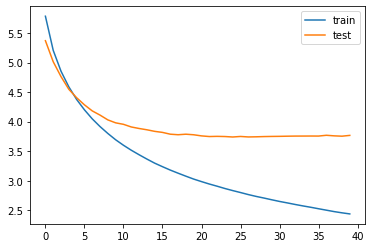

In [110]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [111]:
# 저장된 가장 좋은 모델 로드
seq2seq_attention_best_model = tf.keras.models.load_model('seq2seq_attention_model.keras')

### 인퍼런스 모델 구현

- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 함
- 필요한 3개의 사전을 아래와 같이 미리 준비

In [112]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 별도의 모델 설계 필요함
- 이때는 인코더 모델과 디코더 모델을 분리해서 설계

In [113]:
# 인코더 설계
# encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [117]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(max_text_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [123]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기

In [124]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

In [125]:
# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i == 0):  # 패딩 토큰은 무시합니다.
            continue
        if (i == tar_word_to_index['sostoken']):  # 시작 토큰은 무시합니다.
            continue
        if (i == tar_word_to_index['eostoken']):  # 종료 토큰에서 변환을 멈춥니다.
            break
        temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()  # 마지막 공백 제거

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [239]:
for i in range(0, 50):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 headlines :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, max_text_len)))
    print("\n")

원문 : berkshire hathaway chairman warren buffett said company continue prosper even gone buffett said berkshire success due celebrity status due good business sense comes identifying business opportunities think hang answer need money buffett added 
실제 headlines : berkshire will continue to UNK after am gone buffett
예측 요약 :  buffett should be UNK by any UNK says buffett


원문 : poland UNK retirement age men women UNK previous reform gradually raising UNK retirement age country deputy prime minister UNK UNK defended government move saying women right retire earlier responsibilities including raising children 
실제 headlines : poland to bring back different retirement age for men women
예측 요약 :  UNK UNK UNK UNK UNK to be UNK


원문 : journalist blogger abhijit iyer mitra arrested alleged derogatory remarks odisha UNK sun temple granted bail pointing sculptures temple complex video uploaded september mitra said holy place later tweeted jokes aside temple mind blowing 
실제 headlines : journo held 

예측 요약 :  prince harry meghan markle wedding with royal wedding


원문 : former australian pacer glenn mcgrath gave advice age group cricketers haryana revealing helped haryana cricketers action mcgrath talked players wishing play indian premier league saying want go back ipl next year yes work hard rest months 
실제 headlines : ex aus pacer mcgrath shares knowledge with haryana cricketers
예측 요약 :  UNK UNK UNK UNK to be given from aus


원문 : akshay kumar took twitter share fan rap video upcoming film toilet ek prem katha praised video fan named abhishek bhatt wrote made video thank mr UNK always inspiring us film plot aligned principles pm narendra modi swachh bharat abhiyaan 
실제 headlines : akshay praises fan rap video on toilet ek prem katha
예측 요약 :  akshay shares video of akshay fan dancing with toilet


원문 : japanese UNK company holding contest offer couple night lord lady UNK castle UNK city nagasaki UNK around student volunteers dressed full armour greet winning couple city officials 

예측 요약 :  us president UNK UNK manning over leaking war


원문 : punjab chief minister amarinder singh wednesday said farmers cannot expected give stubble burning completely provided viable solutions adding matter farmers livelihood survival said state government engaged spreading awareness among farmers need stop burning stubble 
실제 headlines : farmers cannot give up stubble burning completely punjab cm
예측 요약 :  stubble burning stubble stubble stubble stubble stubble


원문 : murder accused shot sitting inside police van gate number delhi UNK UNK court tuesday reportedly shooter minor belonged rival gang man admitted hospital shooter taken custody police 
실제 headlines : murder accused shot at outside delhi UNK UNK court
예측 요약 :  journalist shot dead in delhi court


원문 : india second largest telecom operator bharti airtel reportedly talks regarding potential takeover UNK kenya east african nation smallest operator london based UNK investment looking sell part stake UNK acquired reports add

- 원문 : real madrid wait till start next season get hands spanish la liga trophy despite winning league title final UNK atl tico madrid also wait three months presented la liga trophy winning la liga title 
- 실제 headlines : when will real madrid be presented with the la liga trophy
- 예측 요약 :  real madrid bar ends as la liga for first time

위 예에서 보면 real madrid 등 비슷한 단어가 나오긴 하였지만 의미가 많이 다르다.  
요약 품질이 좋지 않다......

### 정량적 평가를 위한 BLEU 점수 계산 (nltk 사용)

In [159]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [253]:
# Smoothing Function을 적용하여 BLEU 계산
smoothie = SmoothingFunction().method4

bleu_scores = []
predicted_summaries = []

for i in range(0, 50):
    reference = seq2summary(decoder_input_test[i]).split()
    candidate = decode_sequence(encoder_input_test[i].reshape(1, max_text_len)).split()
    predicted_summaries.append(candidate)  # 예측 요약을 리스트로 저장
    bleu_score = sentence_bleu([reference], candidate, smoothing_function=smoothie)
    bleu_scores.append(bleu_score)
    
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 headlines :", ' '.join(reference))
    print("예측 요약 :", ' '.join(candidate))
    print("BLEU Score :", bleu_score)
    print("\n")

print("Average BLEU Score for samples 0-50: ", np.mean(bleu_scores))

원문 : berkshire hathaway chairman warren buffett said company continue prosper even gone buffett said berkshire success due celebrity status due good business sense comes identifying business opportunities think hang answer need money buffett added 
실제 headlines : berkshire will continue to UNK after am gone buffett
예측 요약 : buffett should be UNK by any UNK says buffett
BLEU Score : 0.030601688609851067


원문 : poland UNK retirement age men women UNK previous reform gradually raising UNK retirement age country deputy prime minister UNK UNK defended government move saying women right retire earlier responsibilities including raising children 
실제 headlines : poland to bring back different retirement age for men women
예측 요약 : UNK UNK UNK UNK UNK to be UNK
BLEU Score : 0.0222734042410851


원문 : journalist blogger abhijit iyer mitra arrested alleged derogatory remarks odisha UNK sun temple granted bail pointing sculptures temple complex video uploaded september mitra said holy place later twee

원문 : picture team india head coach ravi shastri lookalike mumbai local gone viral social media users turned picture meme one writing ravi shastri looking like gupta uncle lives next door works bank reaction shastri match day virat kohli playing wrote another user 
실제 headlines : ravi shastri lookalike boards mumbai local picture goes viral
예측 요약 : ravi shastri posts picture with ravi shastri in mumbai
BLEU Score : 0.07517081801936397


원문 : us actress meghan markle made official appearance alongside fianc prince harry elder brother william wife kate wednesday first time britain royal UNK four took part public engagement markle marry prince harry may year couple marked first joint royal visit december last year 
실제 headlines : meghan markle attends st event as part of uk royal UNK four
예측 요약 : prince harry meghan markle wedding with royal wedding
BLEU Score : 0.04781031568177268


원문 : former australian pacer glenn mcgrath gave advice age group cricketers haryana revealing helped haryan

원문 : us president donald trump saturday explained deployment terminal high altitude area defence system south korea china president xi jinping trump also discussed seriousness north korea nuclear problem respond notably china opposed deployment us supplied UNK south korea arguing could threaten security 
실제 headlines : trump explains us position on thaad to china
예측 요약 : trump to develop new korea to monitor trump kim summit
BLEU Score : 0.027895820162122397


원문 : rape allegations levelled portugal footballer cristiano ronaldo led fall price shares new club juventus accusations levelled former real madrid player sports firm nike expressed deep concern matter stated closely monitoring situation 
실제 headlines : juventus shares fall after rape allegations against ronaldo
예측 요약 : neymar loses over UNK in UNK at instagram
BLEU Score : 0


원문 : former us army intelligence analyst chelsea manning released military prison kansas wednesday took twitter share picture world okay everyone manning

#### Average BLEU Score for samples 0-50:  0.045445285592722984
- 점수가 너무 낮아서 모델 성능이 안 좋다!!
- 모델이 문제인지 전처리 과정이 잘 못되었는지 혹은 모델 테스트 과정이 잘 못되었는지 확인이 필요 해 보인다.

### 정량적 평가를 위한 Perplexity 계산

In [161]:
def calculate_perplexity(model, input_sequences, target_sequences):
    perplexities = []
    for i in range(len(input_sequences)):
        input_seq = input_sequences[i].reshape(1, max_text_len)
        target_seq = target_sequences[i].reshape(1, -1)
        predictions = model.predict([input_seq, target_seq[:, :-1]])
        cross_entropy = 0.0
        for t in range(target_seq.shape[1] - 1):
            true_index = target_seq[0, t + 1]
            predicted_prob = predictions[0, t, true_index]
            cross_entropy -= np.log(predicted_prob + 1e-10)
        perplexity = np.exp(cross_entropy / (target_seq.shape[1] - 1))
        perplexities.append(perplexity)
    return np.mean(perplexities)

In [162]:
# 테스트 데이터에 대해 Perplexity 계산
perplexity = calculate_perplexity(seq2seq_attention_best_model, encoder_input_test, decoder_input_test)
print("Perplexity on test data: ", perplexity)

Perplexity on test data:  522.5047226909389


#### Perplexity on test data:  522.5047226909389
- 일반적으로 Perplexity 값이 10~100 이하이면 모델이 비교적 좋은 예측을 하고 있다고 평가
- 현재 모델은 매우 큰 수치로 모델의 성능이 안 좋다!!

### Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

### summarize 사용하기
---
Summa의 summarize()의 인자

> text (str) : 요약할 테스트.  
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
words (int or None, optional) – 출력에 포함할 단어 수.  
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.  
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환  

- Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
- 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있음
- 원문의 0.005%만을 출력하도록 설정

In [202]:
import requests
from summa.summarizer import summarize

In [215]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
result_summarize_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [236]:
indices

array([49998, 25628, 39317, ..., 59050, 14130, 77167])

In [237]:
result_summarize_data = result_summarize_data.iloc[indices]
result_summarize_data.iloc[:10]

,headlines,text
15957,Shahzad 1st Afghan player to score an int'l to...,Afghanistan's wicketkeeper-batsman Mohammad Sh...
5610,MakeMyTrip files lawsuit against 5 firms over ...,Online travel portal MakeMyTrip (MMT) has file...
63340,Samsung announces three new CEOs,Samsung on Monday announced it has promoted th...
87019,India defeat Pakistan in pre-Champions Trophy ...,Indian fans defeated their Pakistani counterpa...
30939,Report on flyover collapse to be submitted in ...,Uttar Pradesh CM Yogi Adityanath has said a th...
46710,Tamil Nadu incubator to invest Ã¢ÂÂ¹1.3 crore...,Tamil Nadu-based incubator will be investing Ã...
26535,Axis Bank recommends three candidates for the ...,Axis Bank on Tuesday said it has recommended t...
34643,Tendulkar could play Doctor Strange: Benedict ...,"Actor Benedict Cumberbatch, who played the lea..."
24209,MP CM Chouhan slams Digvijaya for calling Lade...,Madhya Pradesh CM Shivraj Singh Chouhan has sl...
18588,Neymar copies Ronaldo's celebration after scor...,Brazilian forward Neymar Jr copied former Real...


In [254]:
extractive_summaries = []

In [255]:
for idx in range(0, 50):
    head = result_summarize_data['headlines'].iloc[idx]
    text = result_summarize_data['text'].iloc[idx]
    extractive_summary = summarize(text, ratio=0.40)
    extractive_summaries.append(extractive_summary)
    print("원문 :", text)
    print("실제 요약 :", head)
    print("추출적 요약 :", extractive_summary)
    print("\n")
    

원문 : Afghanistan's wicketkeeper-batsman Mohammad Shahzad became the first player from the nation to score a ton against India in international cricket after reaching the landmark in their Asia Cup 2018 match on Tuesday. The 30-year-old reached the landmark when Afghanistan were on 131 runs, the joint lowest team score when a batsman has scored an ODI ton.
실제 요약 : Shahzad 1st Afghan player to score an int'l ton against India
추출적 요약 : 


원문 : Online travel portal MakeMyTrip (MMT) has filed a lawsuit against five companies for allegedly violating its trademark by using "deceptively similar sounding names". The firms reportedly include MakeMyYatra, MakeMyJourney, Make My Happy Journey, Pick My Trip and SuperbMyTrip. The Delhi High Court had passed interim orders for a few companies restraining their associated firms from using similar names.
실제 요약 : MakeMyTrip files lawsuit against 5 firms over similar names
추출적 요약 : The Delhi High Court had passed interim orders for a few companies restra

In [247]:
# for idx in range(0, 50):
#     head = seq2summary(decoder_input_test[idx])
#     text = seq2text(encoder_input_test[idx])
#     extractive_summary = summarize(text, ratio=0.40)
#     extractive_summaries.append(extractive_summary)
#     print("원문 :", text)
#     print("실제 요약 :", head)
#     print("추출적 요약 :", extractive_summary)
#     print("\n")

원문 : berkshire hathaway chairman warren buffett said company continue prosper even gone buffett said berkshire success due celebrity status due good business sense comes identifying business opportunities think hang answer need money buffett added 
실제 요약 : berkshire will continue to UNK after am gone buffett
추출적 요약 : 


원문 : poland UNK retirement age men women UNK previous reform gradually raising UNK retirement age country deputy prime minister UNK UNK defended government move saying women right retire earlier responsibilities including raising children 
실제 요약 : poland to bring back different retirement age for men women
추출적 요약 : 


원문 : journalist blogger abhijit iyer mitra arrested alleged derogatory remarks odisha UNK sun temple granted bail pointing sculptures temple complex video uploaded september mitra said holy place later tweeted jokes aside temple mind blowing 
실제 요약 : journo held for derogatory remarks on UNK temple gets bail
추출적 요약 : 


원문 : indian researchers created arti

- 위에서 seq2text(encoder_input_test[idx]) 로 된 text 를 summarize 에 넣으면 추출적 요약이 나오지 않는다 왜 일까?? 이 부분도 디버깅이 필요하다..

### 추출적 요약과 추상적 요약을 비교하는 표 생성

In [256]:
comparison_data = {
    '추상적 요약': [' '.join(summary) for summary in predicted_summaries],
    '추출적 요약': extractive_summaries
}

In [257]:
comparison_df = pd.DataFrame(comparison_data)

In [258]:
comparison_df

,추상적 요약,추출적 요약
0,buffett should be UNK by any UNK says buffett,
1,UNK UNK UNK UNK UNK to be UNK,The Delhi High Court had passed interim orders...
2,UNK UNK arrested for UNK UNK in bihar,Samsung on Monday announced it has promoted th...
3,ai based ai uses users to detect UNK UNK,The Edgbaston Fans Trophy saw teams of Indian ...
4,hc allows us to end floor of consider seats re...,Uttar Pradesh CM Yogi Adityanath has said a th...
5,icici bank chief chanda kochhar to be sold for...,Tamil Nadu-based incubator will be investing Ã...
6,pak minister UNK UNK UNK at UNK temple,Axis Bank on Tuesday said it has recommended t...
7,india share second highest ever rating since U...,Cumberbatch further revealed he loved playing ...
8,russian football player sues UNK for UNK,
9,people die after UNK UNK in maharashtra,Brazilian forward Neymar Jr copied former Real...


- seq2text(encoder_input_test[idx]) 를 이용하면 Extractive 요약이 생성이 되지 않아 indices 을 이용해서 result_summarize_data 를 인덱싱 하였음
- 하지만 Extractive 요약과 Abstractive 요약의 index 가 맞지 않는다;;;
- 이 부분도 시간을 가지고 다시 디버깅 해봐야 할 거 같다

### 회고

- 자연어 모델에 데이터를 넣기 까지 해야 할 일이 너무 많다
- 튜토리얼 없이 처음 부터 끝까지 할 수 있을까?? 라는 의문이 생겼다.
- 단어의 등장 빈도 수를 예제와 같이 7회 미만과 6회 미만으로 잡았는데 기준이 모호 했지만 통계 결과에서는 큰 문제가 없어 보였다.
- Average BLEU Score for samples 50-100: 0.04884201194004173 
- Perplexity on test data:  522.5047226909389
- BLEU Score 와 Perplexity 점수가 좋지 않았는데 모델이 문제인지 전처리 과정이 잘 못되었는지 혹은 모델 테스트 과정이 잘 못되었는지 확인이 필요 해 보인다.
- seq2seq with Attenstion 모델에 대해 자세하게 학습 할 수 있어서 좋았다.
-  Extractive 요약과 Abstractive 요약 table 을 만들기 위한 함수를 만들었는데 두개 index 가 맞지 않는다 이 부분 디버깅이 필요하다.

루브릭  

아래의 기준을 바탕으로 프로젝트를 평가합니다.

---

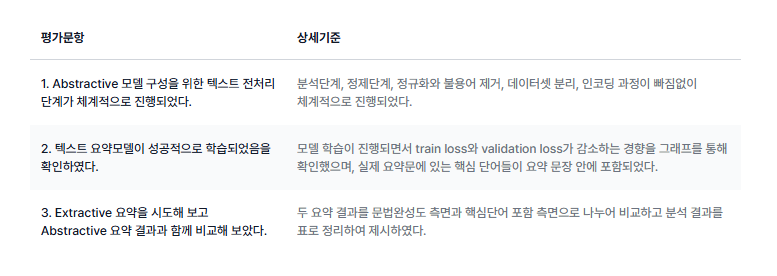